# PART 5: Principal Component Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import pickle

%config InlineBackend.figure_format = 'retina'

### 5.1 Retrieving elements from steps 1-4

#### 5.1.1 Retrieving data harvested in step 1, clened in step 2, and enhanced in step 3 from csv files to dataframes

In [2]:
AW_comments_df = pd.read_csv('../data/aw_com.csv')
AW_posts_df = pd.read_csv('../data/aw_pos.csv')
AM_comments_df = pd.read_csv('../data/am_com.csv')
AM_posts_df = pd.read_csv('../data/am_pos.csv')

#### 5.1.2 Pulling in additional stop words from step 3

In [3]:
stops = stopwords.words('english')
additions = ["!","?",".",":",";", ",", "\'", "\"","*", "'", '"', "[", ']', '(', ")", '’', '-', '...', '&', '|', '\”']
stops.extend(additions)

#### 5.1.3 Retrieving estimators pickled in step 4

In [4]:
svm_pipe_gs_best_estimator = pickle.load(open('../pickles/svm_pipe_gs.p', 'rb'))
logreg_pipe_gs_best_estimator = pickle.load(open('../pickles/logreg_pipe_gs.p', 'rb'))
rfc_pipe_gs_best_estimator = pickle.load(open('../pickles/rfc_pipe_gs.p', 'rb'))
xgbc_pipe_gs_best_estimator = pickle.load(open('../pickles/xgbc_pipe_gs.p', 'rb'))
mnb_pipe_gs_best_estimator = pickle.load(open('../pickles/mnb_pipe_gs.p', 'rb'))

#### 5.1.4 Building X and y variables and performint train_test_split from step 4

In [5]:
X_cont = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)


X_sent_emo = pd.concat([AW_posts_df[AW_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']], 
                        AW_comments_df[AW_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']],
                        AM_posts_df[AM_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score','emojis']], 
                        AM_comments_df[AM_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']]], axis = 0)

X = pd.concat([X_cont, X_sent_emo], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_cont,y, test_size = 0.1, random_state = 11)

In [6]:
tvec = TfidfVectorizer()#stop_words='english')
tvec.fit(X_train)

TfidfVectorizer()

### 5.2. Analysis

#### 5.2.1 2-D comparison of true and predicted classes vs Principal Components

In [7]:
models = ['xgbc', 'logreg','rfc', 'mnb','svm']
estimators = [xgbc_pipe_gs_best_estimator, logreg_pipe_gs_best_estimator, rfc_pipe_gs_best_estimator, mnb_pipe_gs_best_estimator, 
              svm_pipe_gs_best_estimator]
mod_est = {model: estimator for model, estimator in zip(models, estimators)}

In [8]:
def compare_true_predict_pca(model):
    if model in models:
        pca = PCA(n_components=2)
        X_cont_vec = tvec.transform(X_cont)
        pcomps = pca.fit_transform(pd.DataFrame(X_cont_vec.todense())) # only word vector
        pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2'])

        pcomps_df['true'] = y
        pcomps_df[model] = mod_est[model].predict(X_cont)

        plt.figure(figsize = (17,6))
        plt.suptitle('Principal Component Analysis for vectorized reddit entries')
        plt.subplot(1,2,1)
        plt.title('True labels (0 = "AskWomen", 1 = "AskMen")')
        sns.scatterplot(data = pcomps_df, x = 'pc 1', y = 'pc 2', hue = 'true', alpha = 0.2, palette = ['#ff355e','#536878'])

        plt.subplot(1,2,2)
        plt.title(f'Labels predicted by {model} model (0 = "AskWomen", 1 = "AskMen")')
        sns.scatterplot(data = pcomps_df, x = 'pc 1', y = 'pc 2', hue = model, alpha = 0.2, palette = ['#ff355e','#536878'])
    else:
        print('Please select a valid model from the list above')


**The function defined above and invoked below takes 'xgbc', 'logreg','rfc', 'mnb', and 'svm' as input and outputs a 2-d comparison of PCA between real classes and classes predicted by the chosen model**

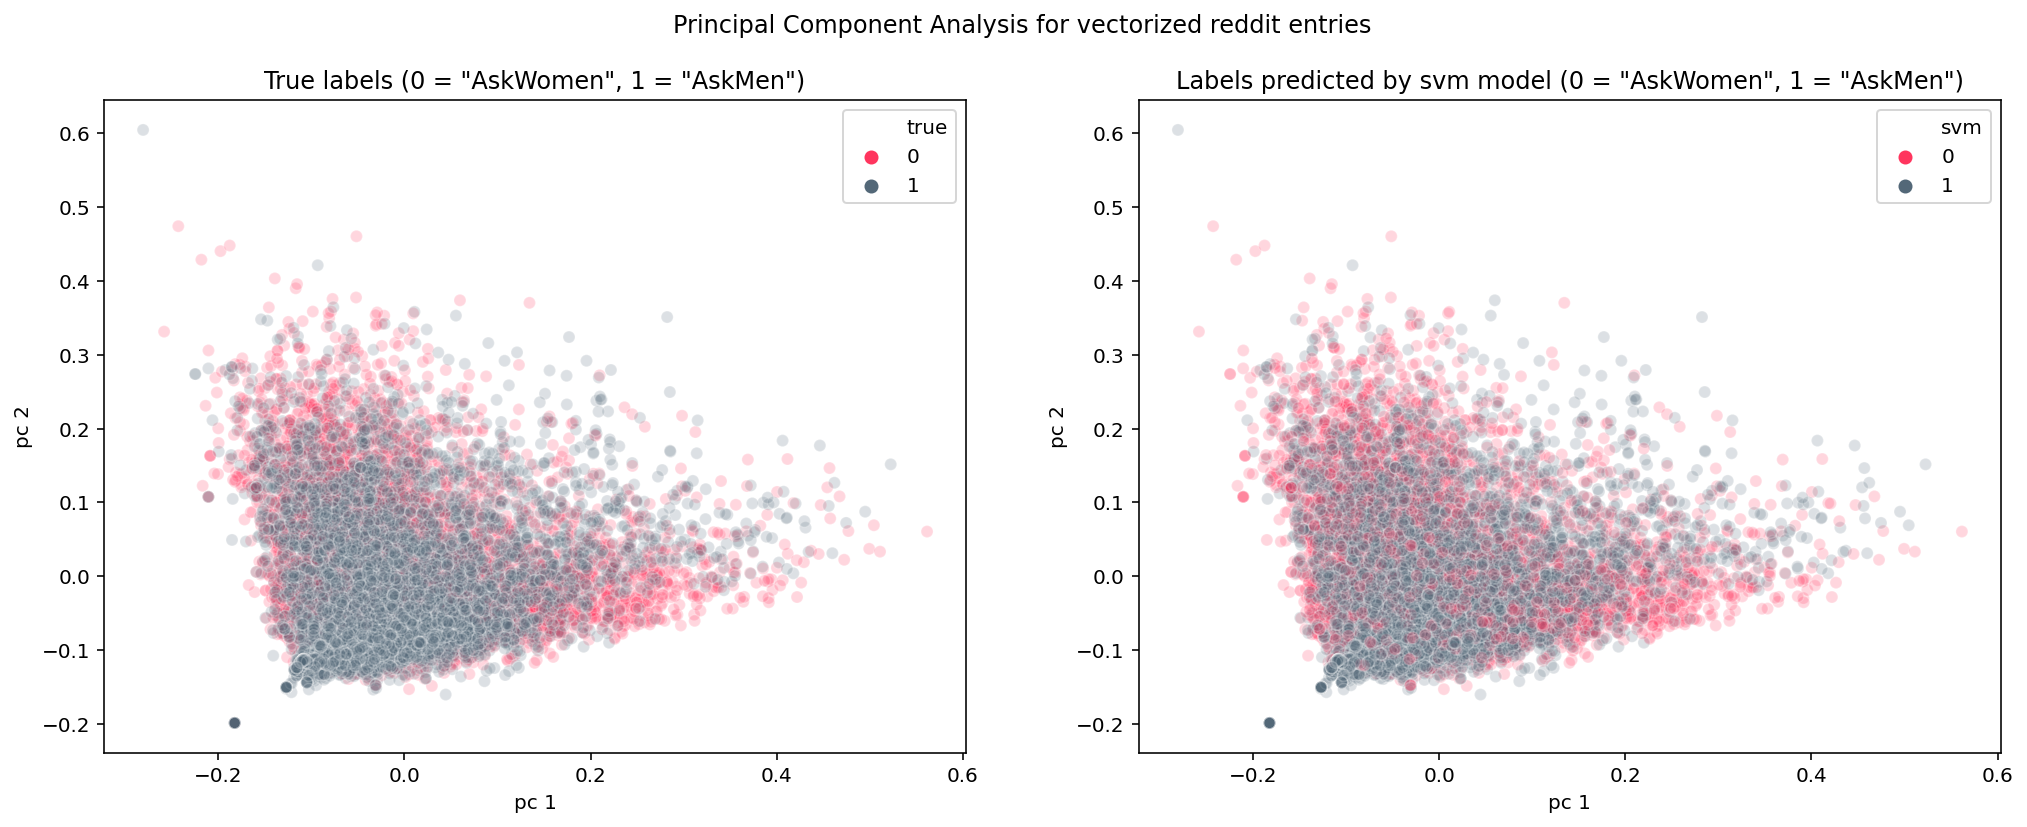

In [9]:
compare_true_predict_pca('svm')
plt.savefig('../visualizations/pca2d.png')

#### 5.2.2 3-D visualization of real classes vs Principal Components

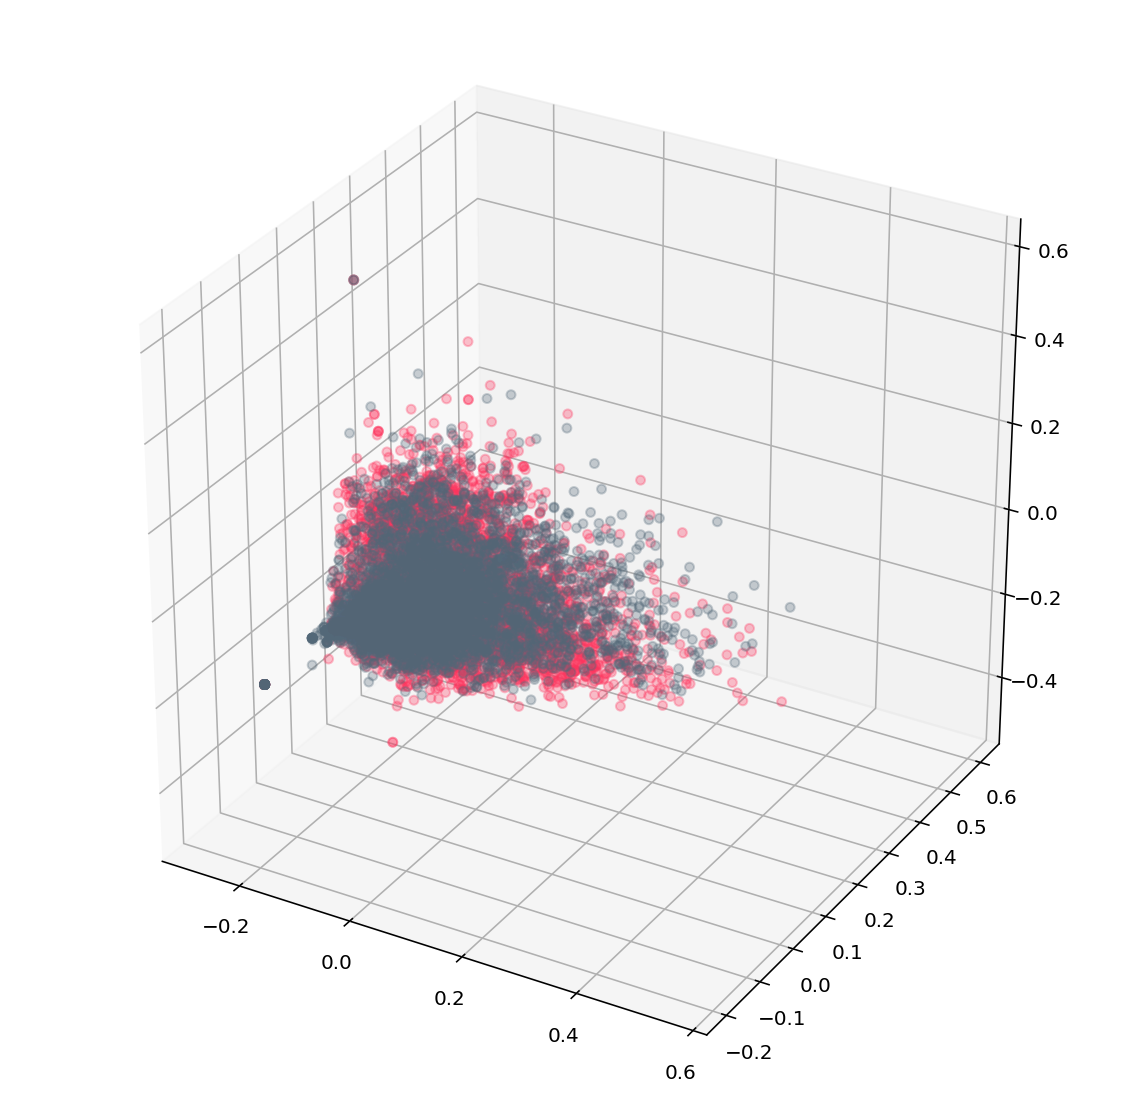

<Figure size 504x504 with 0 Axes>

In [10]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)
X_cont_vec = tvec.transform(X_cont)
pcomps = pca.fit_transform(pd.DataFrame(X_cont_vec.todense())) # only word vector
pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2', 'pc 3'])
pcomps_df['true'] = y
pcomps_df['col_true'] = pcomps_df['true'].map({0: '#ff355e', 1: '#536878'})

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_true']);
fig.savefig('../visualizations/pca3d-true.png')

#### 5.2.3 3-D visualization of classes predicted by candidate estimators vs Principal Components

In [11]:
def pred_pca_3d(model):
    if model in models:
        model_str = str(model)
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111, projection='3d')
        pca = PCA(n_components=3)
        X_cont_vec = tvec.transform(X_cont)
        pcomps = pca.fit_transform(pd.DataFrame(X_cont_vec.todense())) # only word vector
        pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2', 'pc 3'])
        pcomps_df[model] = mod_est[model].predict(X_cont)
        pcomps_df['col_pred'] = pcomps_df[model].map({0: '#ff355e',  1: '#536878'})
        
        plt.figure(figsize = (7,7))
        ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_pred']);

        fig.savefig("../visualizations/pca3d-"+model_str+".png") # this does not work - find another way to export!
        
    else:
            print('Please select a valid model from the list above')

**The function defined above and invoked below takes 'xgbc', 'logreg','rfc', 'mnb', and 'svm' as input and outputs a 3-d visual of classes predicted by the chosen model**

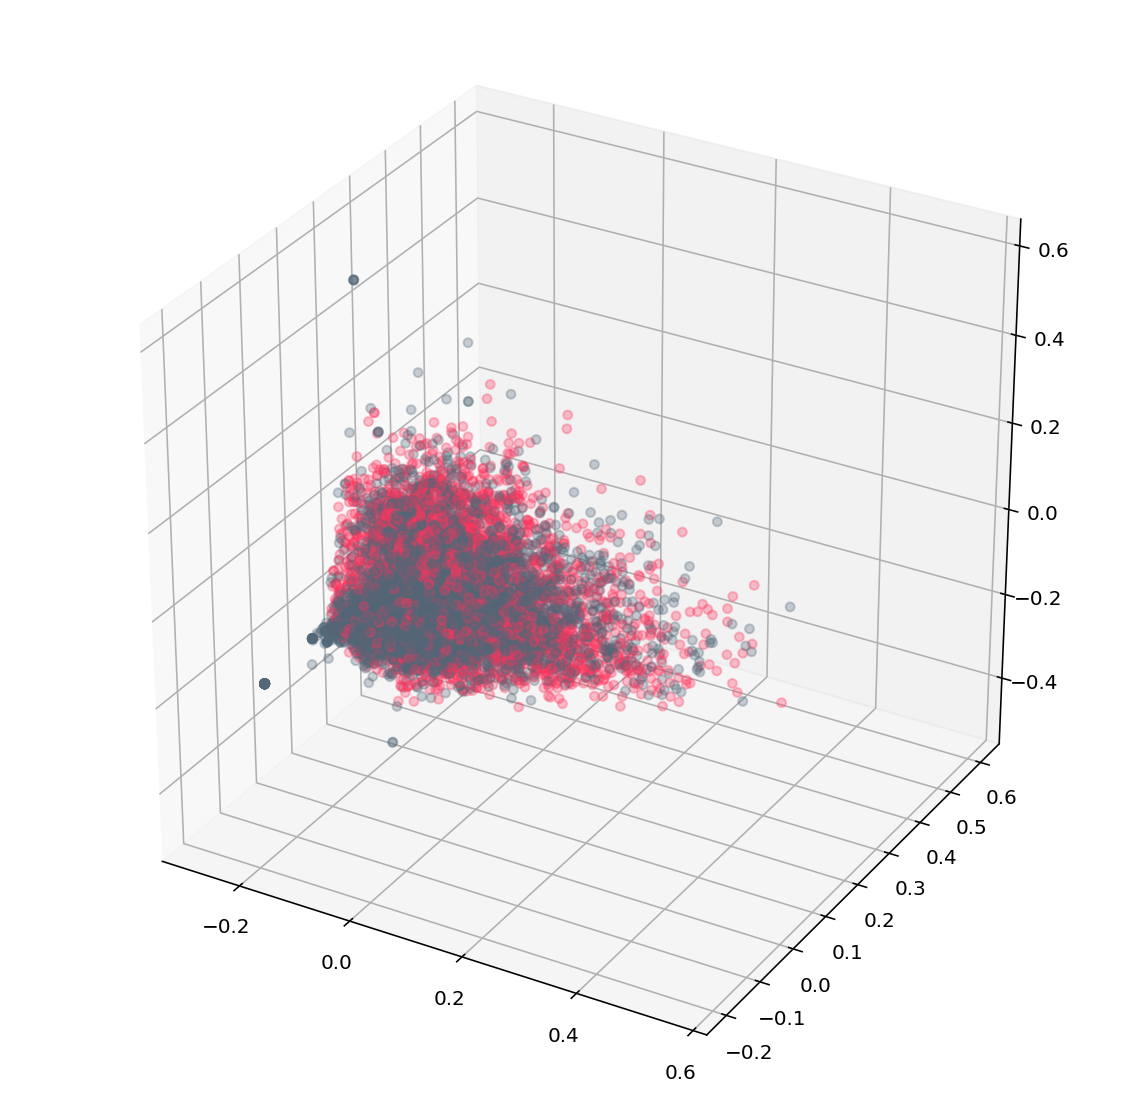

<Figure size 504x504 with 0 Axes>

In [12]:
pred_pca_3d('logreg')

#### 5.2.4 3-D visualization of classes predicted by voting estimator (svm + xgbc + rfc) vs Principal Components

In [14]:
bruteforce_vote = pickle.load(open('../pickles/bf_v.p', 'rb'))

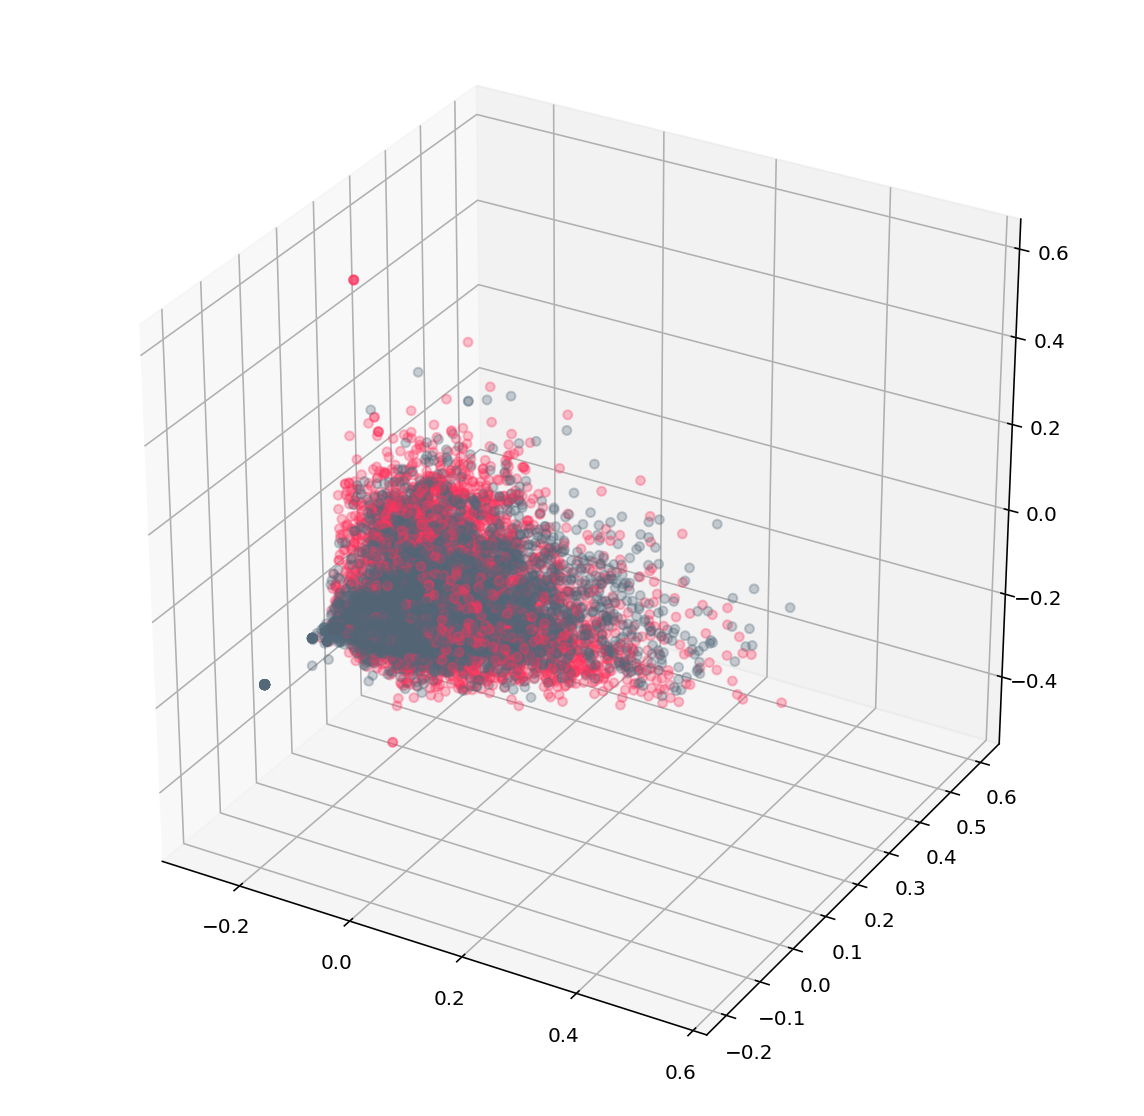

<Figure size 504x504 with 0 Axes>

In [15]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)
X_cont_vec = tvec.transform(X_cont)
pcomps = pca.fit_transform(pd.DataFrame(X_cont_vec.todense())) # only word vector
pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2', 'pc 3'])
pcomps_df['bruteforce_vote'] = bruteforce_vote['prediction']
pcomps_df['col_bfv'] = pcomps_df['bruteforce_vote'].map({0: '#ff355e', 1: '#536878'})

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_bfv']);
fig.savefig('../visualizations/pca3d-bruteforce_vote.png')